# Решающее дерево

### Примечание
### #
Данная лабораторная работа не относится напрямую к изучению питона в целом или какого то конкретного модуля. Задача взята из курса по машинному обучению.
Здесь я хочу проверить ваши умения разбираться в предлагаемом алгоритме и навыки в реализации этих алгоритмов.
Проведем эксперимент и посмотрим на результат. Если будут возникать непреодолимые трудности, то просьба не прибегать к копированию решений из интернета, а обртиться за помощью к коллегам либо преподавателю.
### #

Отметим, что решающее дерево состоит из вершин, в которых записывает некоторое условие, а в листах дерева - прогноз. Условия во внутренних вершинах выбираются простыми. Наиболее частый вариант - проверка лежит ли значение некоторого признака $x^j$ левее порога $t$:

$[x^j \leq t]$

Легко заметить, что такое условие зависит только от одного признака. Прогноз в листе является вещественным числом, если решается задача регрессии. Если же решается задача классификации, то в качестве прогноза выступает или класс или распределение вероятностей классов.

Запишем некоторую функцию ошибки следующим образом: есть набор данных $X_m$, есть номер рассматриваемого признака $j$ и есть порог $t$.

$L(X_m, j, t) \rightarrow \underset{j,t}{min}$

Осуществим перебор всех возможных признаков $j$ и порогов $t$ для этих признаков. Каждый раз исходное множество будет разбиваться на два подмножества:

$X_l = \{x \in X_m | [ x^j \leq t ] \}$ и $X_к = \{x \in X_m | [ x^j > t ] \}$

Такую процедуру можно продолжить для каждого получившегося множества (рекурсивно вызывать функцию деления для получающихся подмножеств).

Необходимо отметить, что если вершина была объявлена листом, необходимо сделать прогноз для этого листа. Для задачи регрессии берется среднее значение по этой выборке,
для задачи классификации возвращается тот класс, которые наиболее популярен в выборке. Можно указывать вероятность классов в листе.

Для каждого разбиения необходимо расчитывать функцию потерь:

$L(X_m, j, t) = \frac{|X_l|}{|X_m|}H(X_l) + \frac{|X_r|}{|X_m|}H(X_r)$,

где $H(X)=\sum\limits_{k=1}^{K} p_k(1 - p_k)$ - критерий информативности Джинни.

$p_k$ - доля объектов класса $k$ в выборке X:

$p_k=\frac{1}{|X|}\sum\limits_{i \in X}{[y_i = k]}$

В задаче работаем только с числовыми данными и строим дерево классификации.

Данные сгенерированы случайным образом.

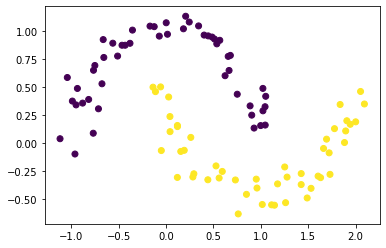

In [91]:
from sklearn.datasets import make_blobs, make_moons, make_multilabel_classification
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

x, y = make_moons(n_samples=100, noise=0.1)
#x, y = make_blobs(n_samples=10000, n_features=2)
plt.scatter(x[:,0], x[:,1], c = y)


## Задание

Напишите класс дерева, который реализует метод train, которая получает на вход матрицу данных ($x$) и целевые переменные ($y$), на выходе функция возвращает дерево в виде словаря в каждом случае записывается номер признака ($i$), порог разбиения($t$), значение в листовой вершине слева ($y_l$) и значение в листовой вершине справа ($y_r$). Вместо занчения в листовой вершине может содержаться следующий словарь с теми же ключами и так далее.

Необходимо учесть:

1. Возможность строить дерево строго определенной глубины и возможность указать максимальное количество объектов в листовой вершине.
2. Пороги разбиения должны лежать строго по середине между ближайшими обектами.
3. Разбиений не требуется, если в получившемся множестве находятся объекты одного класса.
4. Количество различных классов объектов в целевой переменной может быть больше двух.


In [131]:
class Tree:
    def __init__(self, depth=None, min_num_leaf=1):
        self.depth = depth
        self.min_num_leaf = min_num_leaf # пока не понимаю, что это такое и как это реализовывать

    def _get_cardinality(self, x):
        return len(x)

    def _get_gini(self,
                  x_cardinality,
                  classes):
        gini_value = 0
        for class_ in classes.items():
            inclass_count = class_[1]
            partition = inclass_count/x_cardinality
            gini_value += (partition*(1-partition)) 
        return gini_value
    
    def _get_losses_value(self,
                          x_left_cardinality,
                          x_right_cardinality,
                          x_parent_cardinality,
                          left_classes,
                          right_classes):
        left_gini = self._get_gini(x_left_cardinality,
                                   left_classes)
        left_loss = (x_left_cardinality/x_parent_cardinality)*left_gini

        right_gini = self._get_gini(x_right_cardinality,
                                    right_classes)
        right_loss = (x_right_cardinality/x_parent_cardinality)*right_gini

        return left_loss + right_loss

    def _count_classes(self, x_y, start=0, end=None, classes=set()):
        end = len(x_y) if end == None else end
        if start < 0 or end > len(x_y):
            raise ValueError()
        class_counter_dict = {s: 0 for s in classes}
        for i in range(start, end):
            entry = x_y[i]
            entry_class = entry[len(entry)-1]
            class_counter_dict[entry_class] += 1
        return class_counter_dict


    def _get_partition(self, x_y, classes): #O(f*n*log(n)) сделать разбивку на max_num_leaf*2^(depth-cur_depth)
        minloss = 1
        needed_threshold = 0
        needed_j = 0  
        split_index = 0
        class_column_index = len(x_y[0])-1
        for j in range(class_column_index):
            localminloss = minloss
            local_threshold = 0
            local_split_index = 0
            right_class_counts = self._count_classes(x_y,
                                                     start=self.min_num_leaf-1,
                                                     end=len(x_y),
                                                     classes=classes)
            left_class_counts = self._count_classes(x_y,
                                                    start=0,
                                                    end=self.min_num_leaf-1,
                                                    classes=classes)
            x_y = sorted(x_y, key=lambda s : s[j]) # перестать создавать копию
            for i in range(self.min_num_leaf-1, len(x_y) - self.min_num_leaf):
                t = (x_y[i][j] + x_y[i+1][j])/2
                left_class_counts[x_y[i][class_column_index]] += 1
                right_class_counts[x_y[i][class_column_index]] -= 1
                x_y_cardinality = self._get_cardinality(x_y)
                losses = self._get_losses_value(i+1,
                                                x_y_cardinality - i - 1,
                                                x_y_cardinality,
                                                left_class_counts,
                                                right_class_counts)
                if localminloss > losses:
                    localminloss = losses
                    local_threshold = t
                    local_split_index = i
            if minloss > localminloss:
                minloss = localminloss
                needed_threshold = local_threshold
                needed_j = j
                split_index = local_split_index 
        x_y = sorted(x_y, key=lambda s: s[needed_j]) # перестать создавать копию        
        return dict(t=needed_threshold,
                    j=needed_j,
                    left_subset=x_y[:split_index+1],
                    right_subset=x_y[split_index+1:len(x_y)])

    def _get_major_class(self, x_y, classes): #O(n)
        class_counter_dict = self._count_classes(x_y, classes=classes)
        max_class_count = -1
        max_class = 0
        for class_count in class_counter_dict.items():
            if class_count[1] > max_class_count:
                max_class = class_count[0]
                max_class_count = class_count[1]
        return dict(max_class=max_class,
                    count=max_class_count)

    def _build_tree(self, x_y, classes, cur_depth): #O(f*n*log^2n)
        major_class_count = self._get_major_class(x_y, classes)
        if (isinstance(self.min_num_leaf, int) and len(x_y) == self.min_num_leaf) or \
           (isinstance(self.depth, int) and cur_depth >= self.depth) or \
           (major_class_count["count"] == len(x_y)):
            return major_class_count["max_class"]
        partition_info = self._get_partition(x_y, classes)
        lsubtree = self._build_tree(partition_info["left_subset"],
                                    classes,
                                    cur_depth+1)
        rsubtree = self._build_tree(partition_info["right_subset"],
                                    classes,
                                    cur_depth+1)
        return dict(i=partition_info["j"],
                    t=partition_info["t"],
                    yl = lsubtree,
                    yr = rsubtree)

    
    def train(self, x, y):
        classes = set(y)
        x_y = np.concatenate((x, y.reshape(len(y),1)), axis=1)
        self._tree = self._build_tree(x_y, classes, 0)
        return self._tree

    
    def predict(self, x):
        node = self._tree
        while isinstance(node, dict):
            if x[node["i"]] <= node["t"]:
                node = node["yl"]
            else:
                node = node["yr"]
        return node

Постройте решающее дерево с глубиной 1, 2 и 3.

Визуализируйте получившиеся результаты классификатора на плоскости. Для этого воспользуйтесь кодом ниже, чтобы построить поверхность. $t$ - порог разбиения $i$ - номер признака.

Код ниже - это склерновское дерево решений, нужно было только для того, чтобы сравнить картинку

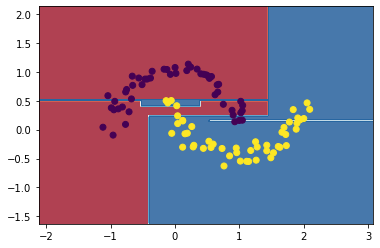

In [139]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(max_depth=10)
clf.fit(x, y)
def tree_clf(x):
    y_pred = list()
    for it in x.transpose():
        cx = clf.predict(it.reshape(1, -1))
        y_pred.append(cx) # Пока дерево классифицирует случайный класс.
    return np.array(y_pred)


h = .02
x0_min, x0_max = np.min(x[:,0]) - 1, np.max(x[:,0]) + 1
x1_min, x1_max = np.min(x[:,1]) - 1, np.max(x[:,1]) + 1
xx0, xx1 = np.meshgrid(np.arange(x0_min, x0_max, h),
                         np.arange(x1_min, x1_max, h))

Z = tree_clf(np.stack((xx0.ravel(),xx1.ravel())))

Z = Z.reshape(xx0.shape)
cm = plt.cm.RdBu
plt.contourf(xx0, xx1, Z, cmap=cm, alpha=.8)
plt.scatter(x[:,0], x[:,1], c = y)


Полученная картинка

{'i': 1, 't': 0.24478382392374415, 'yl': {'i': 0, 't': -0.4093507219757191, 'yl': 0, 'yr': {'i': 1, 't': 0.13329909210956747, 'yl': 1, 'yr': {'i': 1, 't': 0.16606852966598296, 'yl': {'i': 0, 't': 0.5242165990787072, 'yl': 1, 'yr': 0}, 'yr': 1}}}, 'yr': {'i': 0, 't': 1.4437289582557646, 'yl': {'i': 1, 't': 0.5166055708573116, 'yl': {'i': 1, 't': 0.4947291836224281, 'yl': {'i': 1, 't': 0.4017142537612842, 'yl': 0, 'yr': {'i': 0, 't': 0.3890621796611798, 'yl': {'i': 0, 't': -0.5237636587974461, 'yl': 0, 'yr': 1}, 'yr': 0}}, 'yr': 1}, 'yr': 0}, 'yr': 1}}


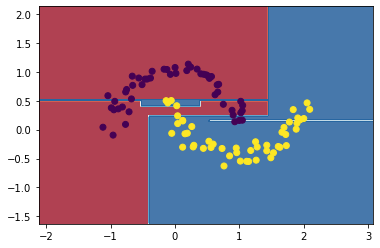

In [138]:
tree = Tree()
print(tree.train(x, y))
def tree_clf(x):
    y_pred = list()
    for it in x.transpose():
        y_pred.append(tree.predict(it)) 
    return np.array(y_pred)


h = .02
x0_min, x0_max = np.min(x[:,0]) - 1, np.max(x[:,0]) + 1
x1_min, x1_max = np.min(x[:,1]) - 1, np.max(x[:,1]) + 1
xx0, xx1 = np.meshgrid(np.arange(x0_min, x0_max, h),
                         np.arange(x1_min, x1_max, h))

Z = tree_clf(np.stack((xx0.ravel(),xx1.ravel())))

Z = Z.reshape(xx0.shape)
cm = plt.cm.RdBu
plt.contourf(xx0, xx1, Z, cmap=cm, alpha=.8)
plt.scatter(x[:,0], x[:,1], c = y)
